**Dataset**
labeled datasset collected from twitter

**Objective**
classify tweets containing hate speech from other tweets. <br>
0 -> no hate speech <br>
1 -> contains hate speech <br>

**Evaluation metric**
macro f1 score

### Import Libraries

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import gensim.downloader as api
from gensim.models import KeyedVectors
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense , Dropout , GlobalMaxPooling1D ,GRU , SimpleRNN , BatchNormalization
from sklearn.metrics import classification_report, f1_score 
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping
from collections import Counter


In [2]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available:  1


### Load Dataset

In [3]:
df = pd.read_csv('Assignment 1\Hate_Speech_Cleaned.csv')
df

,label,tweet,cleaned_tweet
0,0,@user when a father is dysfunctional and is so...,father dysfunctional selfish drag kid dysfunct...
1,0,@user @user thanks for #lyft credit i can't us...,thanks lyft credit cannot use offer wheelchair...
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in ...,model love take time
4,0,factsguide: society now #motivation,factsguide society motivation
...,...,...,...
29126,0,off fishing tomorrow @user carnt wait first ti...,fishing tomorrow carnt wait first time year
29127,0,ate @user isz that youuu?ðððððð...,ate isz youuu
29128,0,to see nina turner on the airwaves trying to w...,see nina turner airwave trying wrap mantle gen...
29129,0,listening to sad songs on a monday morning otw...,listening sad song monday morning otw work sad


In [4]:
print("Null values : \n" , df.isnull().sum())
print('*'*40)
print("Duplicate values : " , df.duplicated().sum())

Null values : 
 label             0
tweet             0
cleaned_tweet    38
dtype: int64
****************************************
Duplicate values :  0


In [5]:
df.dropna(inplace = True)
df.duplicated().sum()

0

In [6]:
x = df['cleaned_tweet']
y = df['label']
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3, stratify=y ,  random_state=88)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5 , stratify=y_temp ,random_state=88)

In [7]:
print('xtrain shape : ' ,x_train.shape) 
print('ytrain shape : ' ,y_train.shape)
print('xval shape : ' ,x_val.shape)
print('yval shape : ' ,y_val.shape)
print('xtest shape : ' ,x_test.shape)
print('ytest shape : ' ,y_test.shape)


xtrain shape :  (20365,)
ytrain shape :  (20365,)
xval shape :  (4364,)
yval shape :  (4364,)
xtest shape :  (4364,)
ytest shape :  (4364,)


## Vectorizing for traditional ML models

In [8]:
class VectorizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, method='tfidf', ngram_range=(1,1), min_df=1, max_df=1.0, embedding_model=None, cnn_model=None):
        self.method = method
        self.ngram_range = ngram_range
        self.min_df = min_df
        self.max_df = max_df
        self.embedding_model = embedding_model
        self.cnn_model = cnn_model
        self.vectorizer = None

    def fit(self, X, y=None):
        if self.method == 'bow':
            self.vectorizer = CountVectorizer(ngram_range=self.ngram_range, min_df=self.min_df, max_df=self.max_df)
            self.vectorizer.fit(X)
        elif self.method == 'tfidf':
            self.vectorizer = TfidfVectorizer(ngram_range=self.ngram_range, min_df=self.min_df, max_df=self.max_df)
            self.vectorizer.fit(X)
        elif self.method in ['word2vec', 'glove', 'fasttext']:
            sentences = [x.split() for x in X]
            if self.embedding_model is not None:
                if not self.embedding_model.wv.key_to_index:  # No vocab yet
                    self.embedding_model.build_vocab(sentences)
                else:
                    self.embedding_model.build_vocab(sentences, update=True)
                self.embedding_model.train(sentences, total_examples=len(sentences), epochs=10)

        elif self.method == 'cnn':
            pass
        return self

    def transform(self, X, y=None):
        if self.method in ['bow', 'tfidf']:
            return self.vectorizer.transform(X)
        
        elif self.method in ['word2vec', 'glove', 'fasttext']:
            return np.array([self._average_vector(text.split()) for text in X])

        elif self.method == 'cnn':
            if self.cnn_model is None:
                raise ValueError("CNN model must be provided for 'cnn' vectorization.")
            return self.cnn_model.predict(X)

    def _average_vector(self, tokens):
        valid_tokens = [token for token in tokens if token in self.embedding_model.wv]
        if not valid_tokens:
            return np.zeros(self.embedding_model.vector_size)
        return np.mean([self.embedding_model.wv[token] for token in valid_tokens], axis=0)


## `Tokenizing & Padding` to Sequence model (RNN , LSTM , GRU)

### Choosing suitable `vocab size` that covers 96% of the data and suitable `max padding length` for the tweet lenght

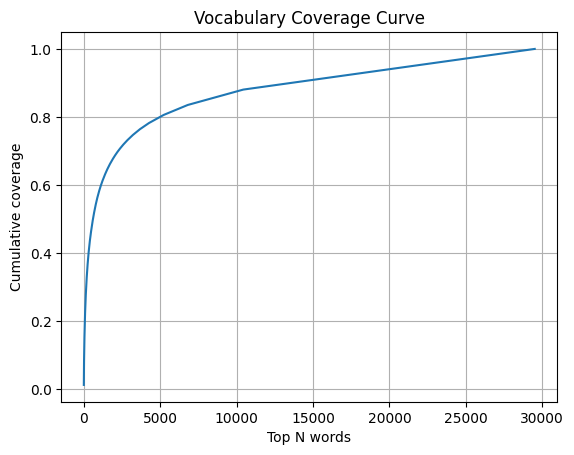

Top 23136 words cover 96.00% of total word usage


In [9]:
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

word_counts = tokenizer.word_counts
sorted_counts = sorted(word_counts.values(), reverse=True)

total = sum(sorted_counts)
cumulative = np.cumsum(sorted_counts) / total

plt.plot(range(len(cumulative)), cumulative)
plt.xlabel("Top N words")
plt.ylabel("Cumulative coverage")
plt.title("Vocabulary Coverage Curve")
plt.grid(True)
plt.show()

coverage = 0.96
cutoff = np.argmax(cumulative >= coverage) + 1 
print(f"Top {cutoff} words cover {cumulative[cutoff-1]*100:.2f}% of total word usage")

tokenizer = Tokenizer(num_words=cutoff, oov_token="<OOV>")
tokenizer.fit_on_texts(x_train)

train_seq = tokenizer.texts_to_sequences(x_train)
val_seq = tokenizer.texts_to_sequences(x_val)
test_seq = tokenizer.texts_to_sequences(x_test)

max_length = 20
x_train_padded = pad_sequences(train_seq, maxlen=max_length, padding='post')
x_val_padded = pad_sequences(val_seq, maxlen=max_length, padding='post')
x_test_padded = pad_sequences(test_seq, maxlen=max_length, padding='post')

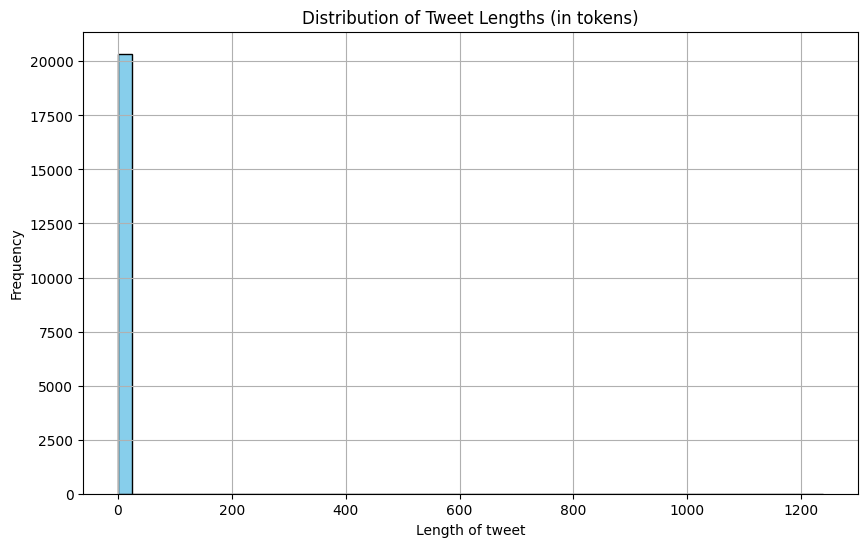

Max length: 1238
95th percentile: 13
Median length: 8


In [10]:
seq_lengths = [len(seq) for seq in train_seq]

plt.figure(figsize=(10, 6))
plt.hist(seq_lengths, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Tweet Lengths (in tokens)")
plt.xlabel("Length of tweet")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

print(f"Max length: {np.max(seq_lengths)}")
print(f"95th percentile: {int(np.percentile(seq_lengths, 95))}")
print(f"Median length: {int(np.median(seq_lengths))}")

## Vectorizing using pre-trained embedding models (Glove - Word2vec - Fasttext)

#### Return embedding matrix for the deep learning models

In [11]:
def build_embedding_matrix(tokenizer, cutoff , method='glove'):
    word_index = tokenizer.word_index
    vocab_size = cutoff
    
    if method == 'glove':
        glove_path = "embeddings_models\glove\glove.twitter.27B.100d.txt"  
        print(f"Loading GloVe embeddings from {glove_path}...")
        embedding_index = {}
        with open(glove_path, encoding='utf8') as f:
            for line in f:
                values = line.split()
                word = values[0]
                vector = np.asarray(values[1:], dtype='float32')
                embedding_index[word] = vector

        embedding_dim = len(next(iter(embedding_index.values())))

    elif method == 'word2vec':
        word2vec_path = "embeddings_models/word2vec/GoogleNews-vectors-negative300.bin.gz"
        print(f"Loading Word2Vec embeddings from {word2vec_path}...")
        model = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
        embedding_dim = model.vector_size
        embedding_index = model

        

    elif method == 'fasttext':
        ft_path = "embeddings_models/fasttext/wiki-news-300d-1M.vec/wiki-news-300d-1M.vec"
        print(f"Loading FastText model from {ft_path}...")
        model = KeyedVectors.load_word2vec_format(ft_path, binary=False)
        embedding_dim = model.vector_size
        embedding_index = model

    else:
        raise ValueError("Unknown embedding method. Choose 'glove', 'word2vec', or 'fasttext'.")

    # Build the embedding matrix
    embedding_matrix = np.zeros((vocab_size + 1, embedding_dim)) 

    for word, i in word_index.items():
        if i > vocab_size:
            continue  
        if word in embedding_index:
            embedding_matrix[i] = embedding_index[word]
    
    print(f"Embedding matrix shape: {embedding_matrix.shape}")
    return embedding_matrix


In [12]:
embedding_matrix_glove = build_embedding_matrix(tokenizer,cutoff=cutoff ,method='glove')
embedding_matrix_w2v = build_embedding_matrix(tokenizer, cutoff=cutoff,method='word2vec')
embedding_matrix_fasttext = build_embedding_matrix(tokenizer,cutoff=cutoff, method='fasttext')

Loading GloVe embeddings from embeddings_models\glove\glove.twitter.27B.100d.txt...
Embedding matrix shape: (23137, 100)
Loading Word2Vec embeddings from embeddings_models/word2vec/GoogleNews-vectors-negative300.bin.gz...
Embedding matrix shape: (23137, 300)
Loading FastText model from embeddings_models/fasttext/wiki-news-300d-1M.vec/wiki-news-300d-1M.vec...
Embedding matrix shape: (23137, 300)


### Defining the embedded layers

In [13]:
max_length = 20

In [14]:
embedding_layer_glove = Embedding(input_dim=cutoff + 1,
                                  output_dim=embedding_matrix_glove.shape[1],
                                  weights=[embedding_matrix_glove],
                                  input_length=max_length,
                                  trainable=True)

In [15]:
embedding_layer_w2v = Embedding(input_dim=cutoff + 1,
                                  output_dim=embedding_matrix_w2v.shape[1],
                                  weights=[embedding_matrix_w2v],
                                  input_length=max_length,
                                  trainable=True)

In [16]:
embedding_layer_fasttext = Embedding(input_dim=cutoff + 1,
                                  output_dim=embedding_matrix_fasttext.shape[1],
                                  weights=[embedding_matrix_fasttext],
                                  input_length=max_length,
                                  trainable=True)

### Computing class weights

In [17]:
class_weight = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weight))
print("Class weights: ", class_weight_dict)

Class weights:  {0: 0.5365988617200674, 1: 7.3308135349172066}


# `Modelling`

In [18]:
early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=3,            
    restore_best_weights=True  
)

### BI-directional `Simple RNN` using `glove` embeddings

In [19]:
model_RNN = Sequential()
model_RNN.add(embedding_layer_glove)
model_RNN.add(Bidirectional(SimpleRNN(32, return_sequences=True)))
model_RNN.add(Dropout(0.3))
model_RNN.add(GlobalMaxPooling1D())
model_RNN.add(Dense(16, activation='relu'))
model_RNN.add(Dropout(0.2))
model_RNN.add(Dense(1, activation='sigmoid'))

model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           2313700   
                                                                 
 bidirectional (Bidirectiona  (None, 20, 64)           8512      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0

In [20]:
model_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_RNN = model_RNN.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val),callbacks=[early_stop] ,class_weight=class_weight_dict,verbose=1)

Epoch 1/10
637/637 [==============================] - 99s 141ms/step - loss: 0.4600 - accuracy: 0.8019 - val_loss: 0.3837 - val_accuracy: 0.8501
Epoch 2/10
637/637 [==============================] - 90s 142ms/step - loss: 0.2647 - accuracy: 0.8937 - val_loss: 0.2320 - val_accuracy: 0.9115
Epoch 3/10
637/637 [==============================] - 93s 146ms/step - loss: 0.1511 - accuracy: 0.9380 - val_loss: 0.2500 - val_accuracy: 0.8934
Epoch 4/10
637/637 [==============================] - 84s 132ms/step - loss: 0.0865 - accuracy: 0.9662 - val_loss: 0.1651 - val_accuracy: 0.9455
Epoch 5/10
637/637 [==============================] - 86s 135ms/step - loss: 0.0534 - accuracy: 0.9802 - val_loss: 0.1870 - val_accuracy: 0.9384
Epoch 6/10
637/637 [==============================] - 87s 137ms/step - loss: 0.0405 - accuracy: 0.9848 - val_loss: 0.2577 - val_accuracy: 0.9145
Epoch 7/10
637/637 [==============================] - 89s 140ms/step - loss: 0.0311 - accuracy: 0.9884 - val_loss: 0.2145 - val_ac

In [21]:
train_loss, train_acc = model_RNN.evaluate(x_train_padded, y_train)
val_loss, val_acc = model_RNN.evaluate(x_val_padded, y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")


137/137 [==============================] - 3s 24ms/step - loss: 0.1651 - accuracy: 0.9455
Train Accuracy: 0.9867419600486755
Validation Accuracy: 0.9454628825187683


In [22]:
y_pred_RNN = model_RNN.predict(x_test_padded)
print("F1-score (RNN)-(glove embedding):", f1_score(y_test, (y_pred_RNN > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_RNN > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 3s 20ms/step
F1-score (RNN)-(glove embedding): 0.7969372923342402
                 precision    recall  f1-score   support

Not Hate Speech       0.97      0.97      0.97      4066
    Hate Speech       0.59      0.65      0.62       298

       accuracy                           0.95      4364
      macro avg       0.78      0.81      0.80      4364
   weighted avg       0.95      0.95      0.95      4364



### BI-directional `Simple RNN` using `word2vec` embeddings

In [23]:
model2_RNN = Sequential()
model2_RNN.add(embedding_layer_w2v)
model2_RNN.add(Bidirectional(SimpleRNN(32, return_sequences=True)))
model2_RNN.add(Dropout(0.3))
model2_RNN.add(GlobalMaxPooling1D())
model2_RNN.add(Dense(16, activation='relu'))
model2_RNN.add(Dropout(0.2))
model2_RNN.add(Dense(1, activation='sigmoid'))

model2_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 300)           6941100   
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 64)           21312     
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 20, 64)            0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dropout_3 (Dropout)         (None, 16)               

In [24]:
model2_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2_RNN = model2_RNN.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val) ,callbacks=[early_stop] ,class_weight=class_weight_dict, verbose=1)

Epoch 1/10
637/637 [==============================] - 86s 129ms/step - loss: 0.4076 - accuracy: 0.8268 - val_loss: 0.3847 - val_accuracy: 0.8268
Epoch 2/10
637/637 [==============================] - 84s 132ms/step - loss: 0.1621 - accuracy: 0.9430 - val_loss: 0.1897 - val_accuracy: 0.9299
Epoch 3/10
637/637 [==============================] - 84s 132ms/step - loss: 0.0759 - accuracy: 0.9739 - val_loss: 0.1566 - val_accuracy: 0.9468
Epoch 4/10
637/637 [==============================] - 7336s 12s/step - loss: 0.0446 - accuracy: 0.9846 - val_loss: 0.1757 - val_accuracy: 0.9441
Epoch 5/10
637/637 [==============================] - 37s 59ms/step - loss: 0.0245 - accuracy: 0.9916 - val_loss: 0.2310 - val_accuracy: 0.9283
Epoch 6/10
637/637 [==============================] - 29s 46ms/step - loss: 0.0204 - accuracy: 0.9925 - val_loss: 0.2060 - val_accuracy: 0.9404


In [25]:
train_loss, train_acc = model2_RNN.evaluate(x_train_padded, y_train)
val_loss, val_acc = model2_RNN.evaluate(x_val_padded, y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

137/137 [==============================] - 1s 6ms/step - loss: 0.1566 - accuracy: 0.9468
Train Accuracy: 0.9878222346305847
Validation Accuracy: 0.9468377828598022


In [26]:
y_pred_RNN2 = model2_RNN.predict(x_test_padded)
print("F1-score (RNN)-(word2vec embedding):", f1_score(y_test, (y_pred_RNN2 > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_RNN2 > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 1s 5ms/step
F1-score (RNN)-(word2vec embedding): 0.781449458698716
                 precision    recall  f1-score   support

Not Hate Speech       0.97      0.97      0.97      4066
    Hate Speech       0.57      0.62      0.59       298

       accuracy                           0.94      4364
      macro avg       0.77      0.79      0.78      4364
   weighted avg       0.94      0.94      0.94      4364



### BI-directional `Simple RNN` using `fasttext` embeddings

In [27]:
model3_RNN = Sequential()
model3_RNN.add(embedding_layer_fasttext)
model3_RNN.add(Bidirectional(SimpleRNN(32, return_sequences=True)))
model3_RNN.add(Dropout(0.3))
model3_RNN.add(GlobalMaxPooling1D())
model3_RNN.add(Dense(16, activation='relu'))
model3_RNN.add(Dropout(0.2))
model3_RNN.add(Dense(1, activation='sigmoid'))

model3_RNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 300)           6941100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 20, 64)           21312     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 20, 64)            0         
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 16)                1040      
                                                                 
 dropout_5 (Dropout)         (None, 16)               

In [28]:
model3_RNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3_RNN = model3_RNN.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val),callbacks=[early_stop] ,class_weight=class_weight_dict, verbose=1)

Epoch 1/10
637/637 [==============================] - 26s 40ms/step - loss: 0.3936 - accuracy: 0.8458 - val_loss: 0.3815 - val_accuracy: 0.8423
Epoch 2/10
637/637 [==============================] - 25s 39ms/step - loss: 0.1384 - accuracy: 0.9516 - val_loss: 0.3012 - val_accuracy: 0.8655
Epoch 3/10
637/637 [==============================] - 24s 38ms/step - loss: 0.0640 - accuracy: 0.9772 - val_loss: 0.1821 - val_accuracy: 0.9326
Epoch 4/10
637/637 [==============================] - 25s 39ms/step - loss: 0.0380 - accuracy: 0.9872 - val_loss: 0.1744 - val_accuracy: 0.9489
Epoch 5/10
637/637 [==============================] - 24s 38ms/step - loss: 0.0217 - accuracy: 0.9927 - val_loss: 0.2154 - val_accuracy: 0.9386
Epoch 6/10
637/637 [==============================] - 25s 39ms/step - loss: 0.0166 - accuracy: 0.9942 - val_loss: 0.2253 - val_accuracy: 0.9432
Epoch 7/10
637/637 [==============================] - 25s 39ms/step - loss: 0.0206 - accuracy: 0.9932 - val_loss: 0.2229 - val_accuracy:

In [29]:
train_loss, train_acc = model3_RNN.evaluate(x_train_padded, y_train)
val_loss, val_acc = model3_RNN.evaluate(x_val_padded, y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

137/137 [==============================] - 1s 6ms/step - loss: 0.1744 - accuracy: 0.9489
Train Accuracy: 0.996169924736023
Validation Accuracy: 0.9489001035690308


In [30]:
y_pred_RNN3 = model3_RNN.predict(x_test_padded)
print("F1-score (RNN)-(fasttext embedding):", f1_score(y_test, (y_pred_RNN3 > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_RNN3 > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 1s 5ms/step
F1-score (RNN)-(fasttext embedding): 0.784774733354854
                 precision    recall  f1-score   support

Not Hate Speech       0.97      0.97      0.97      4066
    Hate Speech       0.59      0.61      0.60       298

       accuracy                           0.94      4364
      macro avg       0.78      0.79      0.78      4364
   weighted avg       0.95      0.94      0.94      4364



### BI-directional `LSTM` using `glove` embeddings

In [31]:
model_LSTM = Sequential()
model_LSTM.add(embedding_layer_glove)
model_LSTM.add(Bidirectional(LSTM(32, return_sequences=True)))
model_LSTM.add(Dropout(0.3))
model_LSTM.add(GlobalMaxPooling1D())
model_LSTM.add(Dense(16, activation='relu'))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(1, activation='sigmoid'))

model_LSTM.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           2313700   
                                                                 
 bidirectional_3 (Bidirectio  (None, 20, 64)           34048     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 20, 64)            0         
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dropout_7 (Dropout)         (None, 16)               

In [32]:
model_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_LSTM = model_LSTM.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val), callbacks=[early_stop] ,class_weight=class_weight_dict, verbose=1)

Epoch 1/10
637/637 [==============================] - 11s 12ms/step - loss: 0.2082 - accuracy: 0.9271 - val_loss: 0.1751 - val_accuracy: 0.9329
Epoch 2/10
637/637 [==============================] - 7s 11ms/step - loss: 0.0762 - accuracy: 0.9703 - val_loss: 0.2437 - val_accuracy: 0.9083
Epoch 3/10
637/637 [==============================] - 7s 11ms/step - loss: 0.0489 - accuracy: 0.9799 - val_loss: 0.2062 - val_accuracy: 0.9200
Epoch 4/10
637/637 [==============================] - 7s 12ms/step - loss: 0.0342 - accuracy: 0.9881 - val_loss: 0.2227 - val_accuracy: 0.9326


In [33]:
train_loss, train_acc = model_LSTM.evaluate(x_train_padded, y_train)
val_loss, val_acc = model_LSTM.evaluate(x_val_padded, y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

137/137 [==============================] - 1s 4ms/step - loss: 0.1751 - accuracy: 0.9329
Train Accuracy: 0.9752025604248047
Validation Accuracy: 0.9328597784042358


In [34]:
y_pred_LSTM = model_LSTM.predict(x_test_padded)
print("F1-score (LSTM)-(glove embedding):", f1_score(y_test, (y_pred_LSTM > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_LSTM > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 1s 3ms/step
F1-score (LSTM)-(glove embedding): 0.771744444735976
                 precision    recall  f1-score   support

Not Hate Speech       0.98      0.95      0.96      4066
    Hate Speech       0.49      0.71      0.58       298

       accuracy                           0.93      4364
      macro avg       0.74      0.83      0.77      4364
   weighted avg       0.94      0.93      0.94      4364



### BI-directional `LSTM` using `word2vec` embeddings

In [35]:
model2_LSTM = Sequential()
model2_LSTM.add(embedding_layer_w2v)
model2_LSTM.add(Bidirectional(LSTM(32, return_sequences=True)))
model2_LSTM.add(Dropout(0.3))
model2_LSTM.add(GlobalMaxPooling1D())
model2_LSTM.add(Dense(16, activation='relu'))
model2_LSTM.add(Dropout(0.2))
model2_LSTM.add(Dense(1, activation='sigmoid'))

model2_LSTM.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 300)           6941100   
                                                                 
 bidirectional_4 (Bidirectio  (None, 20, 64)           85248     
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 20, 64)            0         
                                                                 
 global_max_pooling1d_4 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dropout_9 (Dropout)         (None, 16)               

In [36]:
model2_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2_LSTM = model2_LSTM.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val),callbacks=[early_stop],class_weight=class_weight_dict, verbose=1)

Epoch 1/10
637/637 [==============================] - 14s 19ms/step - loss: 0.1573 - accuracy: 0.9469 - val_loss: 0.1806 - val_accuracy: 0.9258
Epoch 2/10
637/637 [==============================] - 11s 17ms/step - loss: 0.0653 - accuracy: 0.9742 - val_loss: 0.1956 - val_accuracy: 0.9292
Epoch 3/10
637/637 [==============================] - 11s 17ms/step - loss: 0.0328 - accuracy: 0.9874 - val_loss: 0.2035 - val_accuracy: 0.9356
Epoch 4/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0193 - accuracy: 0.9929 - val_loss: 0.5361 - val_accuracy: 0.8311


In [37]:
train_loss, train_acc = model2_LSTM.evaluate(x_train_padded, y_train)
val_loss, val_acc = model2_LSTM.evaluate(x_val_padded, y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

137/137 [==============================] - 1s 4ms/step - loss: 0.1806 - accuracy: 0.9258
Train Accuracy: 0.976184606552124
Validation Accuracy: 0.9257562160491943


In [38]:
y_pred_LSTM2 = model2_LSTM.predict(x_test_padded)
print("F1-score (LSTM)-(word2vec embedding):", f1_score(y_test, (y_pred_LSTM2 > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_LSTM2 > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 1s 4ms/step
F1-score (LSTM)-(word2vec embedding): 0.7547063881708527
                 precision    recall  f1-score   support

Not Hate Speech       0.98      0.94      0.96      4066
    Hate Speech       0.45      0.71      0.55       298

       accuracy                           0.92      4364
      macro avg       0.72      0.82      0.75      4364
   weighted avg       0.94      0.92      0.93      4364



### BI-directional  `LSTM` using `fasttext` embeddings

In [39]:
model3_LSTM = Sequential()
model3_LSTM.add(embedding_layer_fasttext)
model3_LSTM.add(Bidirectional(LSTM(32, return_sequences=True)))
model3_LSTM.add(Dropout(0.3))
model3_LSTM.add(GlobalMaxPooling1D())
model3_LSTM.add(Dense(16, activation='relu'))
model3_LSTM.add(Dropout(0.2))
model3_LSTM.add(Dense(1, activation='sigmoid'))

model3_LSTM.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 300)           6941100   
                                                                 
 bidirectional_5 (Bidirectio  (None, 20, 64)           85248     
 nal)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 20, 64)            0         
                                                                 
 global_max_pooling1d_5 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_10 (Dense)            (None, 16)                1040      
                                                                 
 dropout_11 (Dropout)        (None, 16)               

In [40]:
model3_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3_LSTM = model3_LSTM.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val), callbacks=[early_stop],class_weight=class_weight_dict, verbose=1)

Epoch 1/10
637/637 [==============================] - 13s 17ms/step - loss: 0.1523 - accuracy: 0.9423 - val_loss: 0.2200 - val_accuracy: 0.9207
Epoch 2/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0514 - accuracy: 0.9837 - val_loss: 0.2263 - val_accuracy: 0.9143
Epoch 3/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0284 - accuracy: 0.9911 - val_loss: 0.1874 - val_accuracy: 0.9432
Epoch 4/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0199 - accuracy: 0.9941 - val_loss: 0.2161 - val_accuracy: 0.9352
Epoch 5/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0108 - accuracy: 0.9968 - val_loss: 0.2442 - val_accuracy: 0.9475
Epoch 6/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0066 - accuracy: 0.9981 - val_loss: 0.2651 - val_accuracy: 0.9487


In [41]:
train_loss, train_acc = model3_LSTM.evaluate(x_train_padded, y_train)
val_loss, val_acc = model3_LSTM.evaluate(x_val_padded, y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

137/137 [==============================] - 1s 4ms/step - loss: 0.1874 - accuracy: 0.9432
Train Accuracy: 0.994942307472229
Validation Accuracy: 0.9431713819503784


In [42]:
y_pred_LSTM3 = model3_LSTM.predict(x_test_padded)
print("F1-score (LSTM)-(fasttext embedding):", f1_score(y_test, (y_pred_LSTM3 > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_LSTM3 > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 1s 3ms/step
F1-score (LSTM)-(fasttext embedding): 0.7724055206026958
                 precision    recall  f1-score   support

Not Hate Speech       0.97      0.96      0.97      4066
    Hate Speech       0.53      0.63      0.58       298

       accuracy                           0.94      4364
      macro avg       0.75      0.80      0.77      4364
   weighted avg       0.94      0.94      0.94      4364



In [43]:
model4_LSTM = Sequential()
model4_LSTM.add(embedding_layer_fasttext)
model4_LSTM.add(Bidirectional(LSTM(32, return_sequences=True)))
model4_LSTM.add(Dropout(0.5))
model4_LSTM.add(GlobalMaxPooling1D())
model4_LSTM.add(Dense(8, activation='relu'))
model4_LSTM.add(Dropout(0.3))
model4_LSTM.add(Dense(1, activation='sigmoid'))

model4_LSTM.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 300)           6941100   
                                                                 
 bidirectional_6 (Bidirectio  (None, 20, 64)           85248     
 nal)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 20, 64)            0         
                                                                 
 global_max_pooling1d_6 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 8)                 520       
                                                                 
 dropout_13 (Dropout)        (None, 8)                

In [44]:
model4_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history4_LSTM = model4_LSTM.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val), callbacks=[early_stop],class_weight=class_weight_dict, verbose=1)

Epoch 1/10
637/637 [==============================] - 13s 17ms/step - loss: 0.1663 - accuracy: 0.8959 - val_loss: 0.3791 - val_accuracy: 0.8334
Epoch 2/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0703 - accuracy: 0.9880 - val_loss: 0.2427 - val_accuracy: 0.8978
Epoch 3/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0668 - accuracy: 0.9849 - val_loss: 0.1703 - val_accuracy: 0.9413
Epoch 4/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0471 - accuracy: 0.9908 - val_loss: 0.1782 - val_accuracy: 0.9457
Epoch 5/10
637/637 [==============================] - 11s 17ms/step - loss: 0.0295 - accuracy: 0.9953 - val_loss: 0.2038 - val_accuracy: 0.9505
Epoch 6/10
637/637 [==============================] - 11s 17ms/step - loss: 0.0345 - accuracy: 0.9932 - val_loss: 0.2135 - val_accuracy: 0.9464


In [45]:
train_loss, train_acc = model4_LSTM.evaluate(x_train_padded, y_train)
val_loss, val_acc = model4_LSTM.evaluate(x_val_padded, y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

137/137 [==============================] - 1s 4ms/step - loss: 0.1703 - accuracy: 0.9413
Train Accuracy: 0.9944021701812744
Validation Accuracy: 0.9413382411003113


In [46]:
y_pred_LSTM4 = model4_LSTM.predict(x_test_padded)
print("F1-score (LSTM)-(fasttext embedding):", f1_score(y_test, (y_pred_LSTM4 > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_LSTM4 > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 1s 4ms/step
F1-score (LSTM)-(fasttext embedding): 0.7754524342596172
                 precision    recall  f1-score   support

Not Hate Speech       0.98      0.95      0.96      4066
    Hate Speech       0.52      0.68      0.59       298

       accuracy                           0.93      4364
      macro avg       0.75      0.82      0.78      4364
   weighted avg       0.94      0.93      0.94      4364



In [47]:
model5_LSTM = Sequential()
model5_LSTM.add(embedding_layer_fasttext)
model5_LSTM.add(Bidirectional(LSTM(16, return_sequences=True)))
model5_LSTM.add(Dropout(0.5))
model5_LSTM.add(GlobalMaxPooling1D())
model5_LSTM.add(Dense(8, activation='relu'))
model5_LSTM.add(Dropout(0.3))
model5_LSTM.add(Dense(1, activation='sigmoid'))

model5_LSTM.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 300)           6941100   
                                                                 
 bidirectional_7 (Bidirectio  (None, 20, 32)           40576     
 nal)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 20, 32)            0         
                                                                 
 global_max_pooling1d_7 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 8)                 264       
                                                                 
 dropout_15 (Dropout)        (None, 8)                

In [48]:
model5_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history5_LSTM = model5_LSTM.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val), callbacks=[early_stop],class_weight=class_weight_dict, verbose=1)

Epoch 1/10
637/637 [==============================] - 14s 18ms/step - loss: 0.1496 - accuracy: 0.9627 - val_loss: 0.2747 - val_accuracy: 0.8873
Epoch 2/10
637/637 [==============================] - 11s 17ms/step - loss: 0.0467 - accuracy: 0.9850 - val_loss: 0.1638 - val_accuracy: 0.9473
Epoch 3/10
637/637 [==============================] - 11s 17ms/step - loss: 0.0292 - accuracy: 0.9920 - val_loss: 0.2508 - val_accuracy: 0.9035
Epoch 4/10
637/637 [==============================] - 11s 17ms/step - loss: 0.0316 - accuracy: 0.9900 - val_loss: 0.1946 - val_accuracy: 0.9402
Epoch 5/10
637/637 [==============================] - 11s 17ms/step - loss: 0.0195 - accuracy: 0.9938 - val_loss: 0.2372 - val_accuracy: 0.9368


In [49]:
train_loss, train_acc = model5_LSTM.evaluate(x_train_padded, y_train)
val_loss, val_acc = model5_LSTM.evaluate(x_val_padded, y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")
y_pred_LSTM5 = model5_LSTM.predict(x_test_padded)
print("F1-score (LSTM)-(fasttext embedding):", f1_score(y_test, (y_pred_LSTM5 > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_LSTM5 > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 1s 5ms/step - loss: 0.1638 - accuracy: 0.9473
Train Accuracy: 0.9957279562950134
Validation Accuracy: 0.9472960829734802
137/137 [==============================] - 1s 4ms/step
F1-score (LSTM)-(fasttext embedding): 0.7815396005979967
                 precision    recall  f1-score   support

Not Hate Speech       0.97      0.97      0.97      4066
    Hate Speech       0.59      0.59      0.59       298

       accuracy                           0.94      4364
      macro avg       0.78      0.78      0.78      4364
   weighted avg       0.94      0.94      0.94      4364



# `*Highest Score*`

In [50]:
model6_LSTM = Sequential()
model6_LSTM.add(embedding_layer_fasttext)
model6_LSTM.add(Bidirectional(LSTM(128, return_sequences=True)))
model6_LSTM.add(Dropout(0.5))
model6_LSTM.add(GlobalMaxPooling1D())
model6_LSTM.add(Dense(64, activation='relu'))
model6_LSTM.add(BatchNormalization())
model6_LSTM.add(Dropout(0.3))
model6_LSTM.add(Dense(1, activation='sigmoid'))

model6_LSTM.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 300)           6941100   
                                                                 
 bidirectional_8 (Bidirectio  (None, 20, 256)          439296    
 nal)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 20, 256)           0         
                                                                 
 global_max_pooling1d_8 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization (BatchN  (None, 64)              

In [51]:
model6_LSTM.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history6_LSTM = model6_LSTM.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val), callbacks=[early_stop],class_weight=class_weight_dict, verbose=1)

Epoch 1/10
637/637 [==============================] - 14s 19ms/step - loss: 0.0959 - accuracy: 0.9659 - val_loss: 0.1602 - val_accuracy: 0.9539
Epoch 2/10
637/637 [==============================] - 11s 18ms/step - loss: 0.0561 - accuracy: 0.9838 - val_loss: 0.1544 - val_accuracy: 0.9516
Epoch 3/10
637/637 [==============================] - 11s 18ms/step - loss: 0.0298 - accuracy: 0.9907 - val_loss: 0.2118 - val_accuracy: 0.9555
Epoch 4/10
637/637 [==============================] - 11s 18ms/step - loss: 0.0260 - accuracy: 0.9933 - val_loss: 0.1925 - val_accuracy: 0.9549
Epoch 5/10
637/637 [==============================] - 11s 18ms/step - loss: 0.0202 - accuracy: 0.9949 - val_loss: 0.1971 - val_accuracy: 0.9516


In [52]:
train_loss, train_acc = model6_LSTM.evaluate(x_train_padded, y_train)
val_loss, val_acc = model6_LSTM.evaluate(x_val_padded, y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")
y_pred_LSTM6 = model6_LSTM.predict(x_test_padded)
print("F1-score (LSTM)-(fasttext embedding):", f1_score(y_test, (y_pred_LSTM6 > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_LSTM6 > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 1s 5ms/step - loss: 0.1544 - accuracy: 0.9516
Train Accuracy: 0.9980358481407166
Validation Accuracy: 0.9516498446464539
137/137 [==============================] - 1s 4ms/step
F1-score (LSTM)-(fasttext embedding): 0.804134997219268
                 precision    recall  f1-score   support

Not Hate Speech       0.97      0.98      0.97      4066
    Hate Speech       0.67      0.60      0.63       298

       accuracy                           0.95      4364
      macro avg       0.82      0.79      0.80      4364
   weighted avg       0.95      0.95      0.95      4364



### Bi-directional `GRU` using `glove` embeddings

In [53]:
model_GRU = Sequential()
model_GRU.add(embedding_layer_glove)  
model_GRU.add(Bidirectional(GRU(32, return_sequences=True)))
model_GRU.add(Dropout(0.3))
model_GRU.add(GlobalMaxPooling1D())
model_GRU.add(Dense(16, activation='relu'))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(1, activation='sigmoid'))

model_GRU.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           2313700   
                                                                 
 bidirectional_9 (Bidirectio  (None, 20, 64)           25728     
 nal)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 20, 64)            0         
                                                                 
 global_max_pooling1d_9 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 16)                1040      
                                                                 
 dropout_19 (Dropout)        (None, 16)               

In [54]:
model_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history_GRU = model_GRU.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val), callbacks=[early_stop],class_weight=class_weight_dict, verbose=1)

Epoch 1/10
637/637 [==============================] - 9s 12ms/step - loss: 0.1623 - accuracy: 0.9339 - val_loss: 0.2007 - val_accuracy: 0.9219
Epoch 2/10
637/637 [==============================] - 7s 10ms/step - loss: 0.0611 - accuracy: 0.9774 - val_loss: 0.2068 - val_accuracy: 0.9230
Epoch 3/10
637/637 [==============================] - 7s 10ms/step - loss: 0.0368 - accuracy: 0.9856 - val_loss: 0.2382 - val_accuracy: 0.9173
Epoch 4/10
637/637 [==============================] - 7s 10ms/step - loss: 0.0231 - accuracy: 0.9909 - val_loss: 0.1949 - val_accuracy: 0.9528
Epoch 5/10
637/637 [==============================] - 7s 10ms/step - loss: 0.0192 - accuracy: 0.9925 - val_loss: 0.2346 - val_accuracy: 0.9303
Epoch 6/10
637/637 [==============================] - 7s 10ms/step - loss: 0.0129 - accuracy: 0.9951 - val_loss: 0.2732 - val_accuracy: 0.9271
Epoch 7/10
637/637 [==============================] - 7s 10ms/step - loss: 0.0107 - accuracy: 0.9960 - val_loss: 0.3142 - val_accuracy: 0.9175

In [55]:
train_loss, train_acc = model_GRU.evaluate(x_train_padded, y_train)
val_loss, val_acc = model_GRU.evaluate(x_val_padded, y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")

137/137 [==============================] - 1s 4ms/step - loss: 0.1949 - accuracy: 0.9528
Train Accuracy: 0.995089590549469
Validation Accuracy: 0.9527956247329712


In [56]:
y_pred_GRU = model_GRU.predict(x_test_padded)
print("F1-score (GRU)-(glove embedding):", f1_score(y_test, (y_pred_GRU > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_GRU > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 1s 3ms/step
F1-score (GRU)-(glove embedding): 0.8024585976552142
                 precision    recall  f1-score   support

Not Hate Speech       0.97      0.97      0.97      4066
    Hate Speech       0.64      0.62      0.63       298

       accuracy                           0.95      4364
      macro avg       0.81      0.80      0.80      4364
   weighted avg       0.95      0.95      0.95      4364



In [57]:
model1_GRU = Sequential()
model1_GRU.add(embedding_layer_glove)  
model1_GRU.add(Bidirectional(GRU(32)))
model1_GRU.add(Dense(1, activation='sigmoid'))

model1_GRU.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 100)           2313700   
                                                                 
 bidirectional_10 (Bidirecti  (None, 64)               25728     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,339,493
Trainable params: 2,339,493
Non-trainable params: 0
_________________________________________________________________


In [58]:
model1_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2_GRU = model1_GRU.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val), callbacks=[early_stop],class_weight=class_weight_dict, verbose=1)

Epoch 1/10
637/637 [==============================] - 9s 11ms/step - loss: 0.1144 - accuracy: 0.9671 - val_loss: 0.2274 - val_accuracy: 0.9212
Epoch 2/10
637/637 [==============================] - 6s 10ms/step - loss: 0.0308 - accuracy: 0.9892 - val_loss: 0.4165 - val_accuracy: 0.8634
Epoch 3/10
637/637 [==============================] - 6s 10ms/step - loss: 0.0160 - accuracy: 0.9926 - val_loss: 0.2527 - val_accuracy: 0.9413
Epoch 4/10
637/637 [==============================] - 6s 10ms/step - loss: 0.0098 - accuracy: 0.9962 - val_loss: 0.2742 - val_accuracy: 0.9478


In [59]:
train_loss, train_acc = model1_GRU.evaluate(x_train_padded, y_train)
val_loss, val_acc = model1_GRU.evaluate(x_val_padded, y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")
y_pred_GRU1 = model1_GRU.predict(x_test_padded)
print("F1-score (GRU)-(glove embedding):", f1_score(y_test, (y_pred_GRU1 > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_GRU1 > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 1s 4ms/step - loss: 0.2274 - accuracy: 0.9212
Train Accuracy: 0.9844340682029724
Validation Accuracy: 0.9211732149124146
137/137 [==============================] - 1s 4ms/step
F1-score (GRU)-(glove embedding): 0.7387267777380564
                 precision    recall  f1-score   support

Not Hate Speech       0.98      0.93      0.95      4066
    Hate Speech       0.42      0.71      0.53       298

       accuracy                           0.91      4364
      macro avg       0.70      0.82      0.74      4364
   weighted avg       0.94      0.91      0.92      4364



### Bi-directional `GRU` using `word2vec` embeddings

In [60]:
model2_GRU = Sequential()
model2_GRU.add(embedding_layer_w2v)
model2_GRU.add(Bidirectional(GRU(32, return_sequences=True)))
model2_GRU.add(Dropout(0.5))
model2_GRU.add(GlobalMaxPooling1D())
model2_GRU.add(Dense(16, activation='relu'))
model2_GRU.add(BatchNormalization())
model2_GRU.add(Dropout(0.3))
model2_GRU.add(Dense(1, activation='sigmoid'))

model2_GRU.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 300)           6941100   
                                                                 
 bidirectional_11 (Bidirecti  (None, 20, 64)           64128     
 onal)                                                           
                                                                 
 dropout_20 (Dropout)        (None, 20, 64)            0         
                                                                 
 global_max_pooling1d_10 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_21 (Dense)            (None, 16)                1040      
                                                                 
 batch_normalization_1 (Batc  (None, 16)             

In [61]:
model2_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history2_GRU = model2_GRU.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val), callbacks=[early_stop],class_weight=class_weight_dict, verbose=1)

Epoch 1/10
637/637 [==============================] - 13s 18ms/step - loss: 0.2148 - accuracy: 0.8811 - val_loss: 0.2255 - val_accuracy: 0.9306
Epoch 2/10
637/637 [==============================] - 11s 17ms/step - loss: 0.0888 - accuracy: 0.9727 - val_loss: 0.1877 - val_accuracy: 0.9363
Epoch 3/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0666 - accuracy: 0.9822 - val_loss: 0.1765 - val_accuracy: 0.9400
Epoch 4/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0525 - accuracy: 0.9851 - val_loss: 0.1677 - val_accuracy: 0.9386
Epoch 5/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0417 - accuracy: 0.9881 - val_loss: 0.1449 - val_accuracy: 0.9507
Epoch 6/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0442 - accuracy: 0.9876 - val_loss: 0.1862 - val_accuracy: 0.9452
Epoch 7/10
637/637 [==============================] - 11s 17ms/step - loss: 0.0434 - accuracy: 0.9871 - val_loss: 0.1709 - val_accuracy:

In [62]:
train_loss, train_acc = model2_GRU.evaluate(x_train_padded,y_train)
val_loss, val_acc = model2_GRU.evaluate(x_val_padded,y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")
y_pred_GRU2 = model2_GRU.predict(x_test_padded)
print("F1-score (GRU)-(word2vec embedding):", f1_score(y_test, (y_pred_GRU2 > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_GRU2 > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 1s 5ms/step - loss: 0.1449 - accuracy: 0.9507
Train Accuracy: 0.9958261847496033
Validation Accuracy: 0.9507332444190979
137/137 [==============================] - 1s 4ms/step
F1-score (GRU)-(word2vec embedding): 0.7931532413362831
                 precision    recall  f1-score   support

Not Hate Speech       0.97      0.98      0.97      4066
    Hate Speech       0.66      0.57      0.61       298

       accuracy                           0.95      4364
      macro avg       0.82      0.77      0.79      4364
   weighted avg       0.95      0.95      0.95      4364



In [63]:
model3_GRU = Sequential()
model3_GRU.add(embedding_layer_w2v)  
model3_GRU.add(Bidirectional(GRU(32, return_sequences=True)))
model3_GRU.add(Dropout(0.3))
model3_GRU.add(GlobalMaxPooling1D())
model3_GRU.add(Dense(16, activation='relu'))
model3_GRU.add(Dropout(0.2))
model3_GRU.add(Dense(1, activation='sigmoid'))

model3_GRU.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 300)           6941100   
                                                                 
 bidirectional_12 (Bidirecti  (None, 20, 64)           64128     
 onal)                                                           
                                                                 
 dropout_22 (Dropout)        (None, 20, 64)            0         
                                                                 
 global_max_pooling1d_11 (Gl  (None, 64)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_23 (Dense)            (None, 16)                1040      
                                                                 
 dropout_23 (Dropout)        (None, 16)              

In [64]:
model3_GRU.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history3_GRU = model3_GRU.fit(x_train_padded, y_train, epochs=10, batch_size=32, validation_data=(x_val_padded, y_val), callbacks=[early_stop],class_weight=class_weight_dict, verbose=1)

Epoch 1/10
637/637 [==============================] - 13s 18ms/step - loss: 0.1028 - accuracy: 0.9718 - val_loss: 0.2261 - val_accuracy: 0.9184
Epoch 2/10
637/637 [==============================] - 11s 17ms/step - loss: 0.0288 - accuracy: 0.9910 - val_loss: 0.2184 - val_accuracy: 0.9285
Epoch 3/10
637/637 [==============================] - 11s 17ms/step - loss: 0.0186 - accuracy: 0.9939 - val_loss: 0.2218 - val_accuracy: 0.9423
Epoch 4/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0102 - accuracy: 0.9972 - val_loss: 0.2331 - val_accuracy: 0.9445
Epoch 5/10
637/637 [==============================] - 10s 16ms/step - loss: 0.0092 - accuracy: 0.9962 - val_loss: 0.2533 - val_accuracy: 0.9407


In [65]:
train_loss, train_acc = model3_GRU.evaluate(x_train_padded,y_train)
val_loss, val_acc = model3_GRU.evaluate(x_val_padded,y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Validation Accuracy: {val_acc}")
y_pred_GRU3 = model3_GRU.predict(x_test_padded)
print("F1-score (GRU)-(word2vec embedding):", f1_score(y_test, (y_pred_GRU3 > 0.5).astype(int), average='macro'))
print(classification_report(y_test, (y_pred_GRU3 > 0.5).astype(int), target_names=['Not Hate Speech', 'Hate Speech']))

137/137 [==============================] - 1s 4ms/step - loss: 0.2184 - accuracy: 0.9285
Train Accuracy: 0.9941566586494446
Validation Accuracy: 0.9285059571266174
137/137 [==============================] - 1s 4ms/step
F1-score (GRU)-(word2vec embedding): 0.7611306503931254
                 precision    recall  f1-score   support

Not Hate Speech       0.98      0.95      0.96      4066
    Hate Speech       0.48      0.67      0.56       298

       accuracy                           0.93      4364
      macro avg       0.73      0.81      0.76      4364
   weighted avg       0.94      0.93      0.93      4364



------------------------------------------------------------------------------------------------------------------------------------------------------------

# ` *Results & Conclusion* `

### 1- The highest model score is --> `BI-directional LSTM` using pre-trained `Fasttext` embeddings with : 
####        `i.`   Train Accuracy : 0.998
####        `ii.`  Validation Accuracy: 0.951
####        `iii.` F1-Score : 0.80

### 2- Most of the models are mild overfitting as the data's small regarding our models, Although I used lots of : 
####        - `BatchNormalization( )`
####        - `Multiple Dropout( )`
####        - `GlobalAverage1D( )`
####        - `Adding classweights`
####        - `Calling an Early_stopping`
####        - `I put maximum padding length`
####        - `I put maximum number of words to cover 96% of the corpus`

### 3- I think the `Traditional ML.` models have `better` performance on this data the `(RNN,GRU,LSTM)` 
#### - Best f1-score in Traditional ML`(Random Forest)` using `TF_IDF` vectorizer --> 83% 
#### - Best f1-score in `(LSTM)` using `Fasttext` pre-traind embeddings --> 80%
#### - Due to : 
#####       `i.`  The Data is very small
#####       `ii.` The Data is highly imbalnced
#####       `iii.` The complexity of the RNNS  

----------------------------------------------------------------------------------------------------------------------------------------------------------

#### Done!